In [37]:
import torch
import torch.nn as nn
import data.datasets as dataSource
import torch.utils.data as tdata
import numpy as np
import scipy.constants as _scipy_constants
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import cvxpy as cp

In [28]:
dataset_train, dataset_val = dataSource.Dipole_H_train, dataSource.Dipole_H_val
#print(dataset_train.input_columns)
batch_size = 64
important_cols = ["B_design","aper_x", "aper_y", "fieldTolerance", "maxCurrentDensity" , "rho0", "w_leg_factor", "usedPowerInPercent"]
important_cols_order = sorted(important_cols,key=lambda c: dataset_train.input_columns.index(c))

print(important_cols)
print(important_cols_order)

input_mask = [True if col in important_cols else False for col in dataset_train.input_columns]
train_loader, val_loader = tdata.DataLoader(dataset_train,batch_size), tdata.DataLoader(dataset_val,batch_size)

target_index_dict = {col:i for i,col in enumerate(dataset_train.target_columns)}
target_cols = ["B0","gfr_x_1e-2","gfr_y_1e-2"]
output_mask = [True if col in target_cols else False for col in dataset_train.target_columns]

['B_design', 'aper_x', 'aper_y', 'fieldTolerance', 'maxCurrentDensity', 'rho0', 'w_leg_factor', 'usedPowerInPercent']
['fieldTolerance', 'maxCurrentDensity', 'rho0', 'usedPowerInPercent', 'w_leg_factor', 'B_design', 'aper_x', 'aper_y']


In [29]:
oid = {key : important_cols.index(key) for key in important_cols_order}

def get_dipole_continuous(x: torch.Tensor):
    # x.shape = (b,7) with batchDim b and 6 "actual" inputs 'important cols'
    aper_x = x[:,oid["aper_x"]]
    aper_y = x[:,oid["aper_y"]]
    maxCurrentDensity = x[:,oid["maxCurrentDensity"]]
    fieldTolerance = x[:,oid["fieldTolerance"]]
    B_design = x[:,oid["B_design"]]
    rho0 = x[:,oid["rho0"]]
    w_leg_factor = x[:,oid["w_leg_factor"]]
    usedPowerInPercent = x[:,oid["usedPowerInPercent"]]

    xnorm_unoptimised = -0.36 * torch.log(fieldTolerance) - 0.90
    xnorm_optimised = -0.14 * torch.log(fieldTolerance) - 0.25
    gfr_x = aper_x * rho0
    gfr_y = aper_y * rho0
    dipole_corner_norm_0 = rho0**2+xnorm_unoptimised
    polecorner_x = aper_x + xnorm_unoptimised * aper_y

    w = 2*polecorner_x + 2 * polecorner_x * 0.05
    w_leg = 0.5 * (w + 2 * aper_y) * B_design / 2.15 * w_leg_factor

    totalCurrentDesign = B_design * aper_y / (2 * _scipy_constants.mu_0)
    totalCurrent = usedPowerInPercent * 0.01 * totalCurrentDesign

    A_min = totalCurrentDesign / 1e6 / (maxCurrentDensity * (75 * 0.01))
    coil_width = (A_min *2) ** 0.5
    coil_height = coil_width * 0.5
    
    stack = torch.cat([
        x,
        gfr_x.unsqueeze(1),
        gfr_y.unsqueeze(1),
        xnorm_unoptimised.unsqueeze(1),
        xnorm_optimised.unsqueeze(1),
        dipole_corner_norm_0.unsqueeze(1),
        polecorner_x.unsqueeze(1),
        w.unsqueeze(1),
        w_leg.unsqueeze(1),
        totalCurrentDesign.unsqueeze(1),
        totalCurrent.unsqueeze(1),
        coil_width.unsqueeze(1),
        coil_height.unsqueeze(1),
        A_min.unsqueeze(1),
        ],dim=1)
    return stack


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class MyRegNet(nn.Module):
    def __init__(self,h_size=256):
        super().__init__()
        self.bn0 = nn.BatchNorm1d(len(important_cols)+13, dtype=torch.double)
        self.fc1 = nn.Linear(len(important_cols)+13,h_size, dtype=torch.double)
        #self.bn0 = nn.BatchNorm1d(len(important_cols), dtype=torch.double)
        #self.fc1 = nn.Linear(len(important_cols),h_size, dtype=torch.double)
        self.nl1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(h_size, dtype=torch.double)
        self.do1 = nn.Dropout1d()
        self.fc2 = nn.Linear(h_size,h_size, dtype=torch.double)
        self.nl2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(h_size, dtype=torch.double)
        self.do2 = nn.Dropout1d()
        self.fc3 = nn.Linear(h_size,1, dtype=torch.double)
    def forward(self,x):
        x = get_dipole_continuous(x)
        x = self.bn0(x)
        x = self.fc1(x)
        x = self.nl1(x)
        #x = self.bn1(x)
        #x = self.do1(x)
        x = self.fc2(x)
        x = self.nl2(x)
        #x = self.bn2(x)
        #x = self.do2(x)
        x = self.fc3(x)
        return x

class SeperateNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.B0_Net = MyRegNet()
        self.gfr_x_Net = MyRegNet()
        self.gfr_y_Net = MyRegNet()
    def forward(self,x):
        return torch.cat([self.B0_Net(x),self.gfr_x_Net(x), self.gfr_y_Net(x).to(device)],dim=1) #,torch.zeros((x.shape[0],5))
    
class BdesignAwareNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.large_Bdesign_Net = SeperateNet()
        self.small_Bdesign_Net = SeperateNet()
    

    def forward(self,x):
        #network_selection_mask = (x[:,0] < 0.2).float().unsqueeze(1) 
        #x = network_selection_mask * self.small_Bdesign_Net(x) + (1-network_selection_mask) * x
        #x = (1-network_selection_mask) * self.large_Bdesign_Net(x) + network_selection_mask * x
        #return x[:,:3]
    
        mask = x[:, 0] < 0.2  # True -> smallNet; False -> LargeNet
        output = torch.zeros((x.shape[0],3), dtype=torch.double).to(device)
       
        output[mask] = self.small_Bdesign_Net(x[mask])

        output[~mask] = self.large_Bdesign_Net(x[~mask])

        return output
network = BdesignAwareNet().to(device)

In [31]:
loss_mask_df = dataset_train.dataframe[["B0","gfr_x_1e-2","gfr_y_1e-2"]].mean()

In [32]:
n_epochs = 200
lr = 5e-5
optim = torch.optim.Adam(network.parameters(), lr)
loss_fun = nn.MSELoss()

for epoch in range(n_epochs):
    network.train()
    loss_list = []
    for x,y in train_loader:
        selected_x = x[:,input_mask].double().to(device)
        selected_y = y[:,output_mask].double().to(device)
        pred = network(selected_x)

        #loss_mask = (torch.tensor(list(loss_mask_df))* torch.tensor([10,1,1])).repeat((x.shape[0],1)).to(device)
        loss = loss_fun(pred,selected_y)
        loss_list.append(loss.detach().item())
        optim.zero_grad()
        loss.backward()
        optim.step()
    epoch_train_loss = torch.tensor(loss_list).mean()

    network.eval()
    loss_list = []
    for x,y in val_loader:
        selected_x = x[:,input_mask].double().to(device)
        selected_y = y[:,output_mask].double().to(device)
        pred = network(selected_x)

        #loss_mask = (torch.tensor(list(loss_mask_df))* torch.tensor([10,1,1])).repeat((x.shape[0],1)).to(device)
        loss = loss_fun(pred ,selected_y)
        loss_list.append(loss.detach().item())
    epoch_val_loss = torch.tensor(loss_list).mean()
    print(epoch,epoch_train_loss,epoch_val_loss,end="\r")


KeyboardInterrupt: 

In [33]:
torch.save(network.state_dict(), "reg_net_e-2")

In [34]:
network = BdesignAwareNet().to(device)
network.load_state_dict(torch.load("reg_net_e-2"))

/tmp/ipykernel_1172031/3199894719.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load("reg_net_e-2"))


<All keys matched successfully>

In [35]:
errors = {error_type: {"B0":[],"gfr_x":[],"gfr_y":[]} for error_type in ["abs","rel"]}
scatter_plot_points = {"B0":[],"gfr_x":[],"gfr_y":[]}
single_sample_loader =  tdata.DataLoader(dataset_val, 1)

network.eval()
for x,y in single_sample_loader:
    
    selected_x = x[:,input_mask].double().to(device)
    selected_y = y[:,output_mask].double().to(device)
    pred = network(selected_x)

    scatter_plot_points["B0"].append((pred[:,0].detach().item(),selected_y[:,0].detach().item()))
    scatter_plot_points["gfr_x"].append((pred[:,1].detach().item(),selected_y[:,1].detach().item()))
    scatter_plot_points["gfr_y"].append((pred[:,2].detach().item(),selected_y[:,2].detach().item()))

    #print(pred,selected_y)
    abs_errors = pred - selected_y
    errors["abs"]["B0"].append(abs_errors[:,0].detach().item())
    errors["abs"]["gfr_x"].append(abs_errors[:,1].detach().item())
    errors["abs"]["gfr_y"].append(abs_errors[:,2].detach().item())

    rel_errors = 1 - (pred/selected_y)
    errors["rel"]["B0"].append(rel_errors[:,0].detach().item())
    errors["rel"]["gfr_x"].append(rel_errors[:,1].detach().item())
    errors["rel"]["gfr_y"].append(rel_errors[:,2].detach().item())
mean_errors = {error_type: {quantity: sum(map(lambda v: abs(v),l))/len(l) for quantity, l in dictt.items()} for error_type, dictt in errors.items()}
print(mean_errors)

{'abs': {'B0': 0.01612820105109624, 'gfr_x': 0.006715929211986879, 'gfr_y': 0.002500916396550318}, 'rel': {'B0': 0.05604465309247005, 'gfr_x': 0.04155482379224918, 'gfr_y': 0.07595989269279589}}


In [36]:
cols = {"B0":{"pred":[],"target":[]},"gfr_x":{"pred":[],"target":[]},"gfr_y":{"pred":[],"target":[]}}
single_sample_loader =  tdata.DataLoader(dataset_val, 1)

network.eval()
for x,y in single_sample_loader:
    
    selected_x = x[:,input_mask].double().to(device)
    target = y[:,output_mask].double().to(device)
    pred = network(selected_x)

    cols["B0"]["pred"].append(pred[:,0].detach().item())
    cols["B0"]["target"].append(target[:,0].detach().item())

    cols["gfr_x"]["pred"].append(pred[:,1].detach().item())
    cols["gfr_x"]["target"].append(target[:,1].detach().item())

    cols["gfr_y"]["pred"].append(pred[:,2].detach().item())
    cols["gfr_y"]["target"].append(target[:,2].detach().item())



NameError: name 'pd' is not defined

In [38]:
col_names = [quantity + "_" + col_name for quantity, measures in cols.items() for col_name,_ in measures.items()]
df = pd.DataFrame([row for row in zip(*[col for quantity, measures in cols.items() for _,col in measures.items()])],columns=col_names)

In [48]:
df = df \
.assign(B0_diff=df.apply(lambda r: r["B0_pred"] - r["B0_target"] ,axis=1))\
.assign(gfr_x_diff=df.apply(lambda r: r["gfr_x_pred"] - r["gfr_x_target"] ,axis=1))\
.assign(gfr_y_diff=df.apply(lambda r: r["gfr_y_pred"] - r["gfr_y_target"] ,axis=1))\
.assign(B0_diff_abs=df.apply(lambda r: abs(r["B0_pred"] - r["B0_target"]) ,axis=1))\
.assign(gfr_x_diff_abs=df.apply(lambda r: abs(r["gfr_x_pred"] - r["gfr_x_target"]) ,axis=1))\
.assign(gfr_y_diff_abs=df.apply(lambda r: abs(r["gfr_y_pred"] - r["gfr_y_target"]) ,axis=1))\
.assign(B0_diff_rel=df.apply(lambda r: abs(1 -r["B0_pred"]/r["B0_target"]) ,axis=1))\
.assign(gfr_x_diff_rel=df.apply(lambda r: abs(1 - r["gfr_x_pred"]/r["gfr_x_target"]) ,axis=1))\
.assign(gfr_y_diff_rel=df.apply(lambda r: abs(1 - r["gfr_y_pred"]/r["gfr_y_target"]) ,axis=1))

In [49]:
df

,B0_pred,B0_target,gfr_x_pred,gfr_x_target,gfr_y_pred,gfr_y_target,B0_diff,gfr_x_diff,gfr_y_diff,B0_diff_abs,gfr_x_diff_abs,gfr_y_diff_abs,B0_diff_rel,gfr_x_diff_rel,gfr_y_diff_rel
0,0.496497,0.498709,0.140671,0.153578,0.022302,0.025000,-0.002211,-0.012907,-0.002698,0.002211,0.012907,0.002698,0.004434,0.084041,0.107931
1,0.378825,0.374394,0.097771,0.086895,0.015577,0.015000,0.004431,0.010876,0.000577,0.004431,0.010876,0.000577,0.011834,0.125165,0.038437
2,0.072669,0.054468,0.366631,0.375174,0.077348,0.078160,0.018202,-0.008544,-0.000813,0.018202,0.008544,0.000813,0.334170,0.022773,0.010399
3,0.448187,0.436142,0.174410,0.194313,0.020819,0.025000,0.012046,-0.019902,-0.004181,0.012046,0.019902,0.004181,0.027619,0.102425,0.167248
4,0.045821,0.030133,0.393949,0.414109,0.067736,0.069136,0.015687,-0.020160,-0.001400,0.015687,0.020160,0.001400,0.520589,0.048682,0.020250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15084,1.070149,1.102379,0.280374,0.277833,0.054462,0.055798,-0.032230,0.002541,-0.001336,0.032230,0.002541,0.001336,0.029237,0.009145,0.023949
15085,0.131345,0.124740,0.181204,0.194833,0.022327,0.025000,0.006605,-0.013629,-0.002673,0.006605,0.013629,0.002673,0.052953,0.069953,0.106919
15086,1.450596,1.458197,0.101064,0.111420,0.025857,0.029852,-0.007601,-0.010356,-0.003995,0.007601,0.010356,0.003995,0.005212,0.092947,0.133819
15087,0.025976,0.024901,0.661991,0.669431,0.094495,0.100000,0.001075,-0.007440,-0.005505,0.001075,0.007440,0.005505,0.043184,0.011113,0.055048


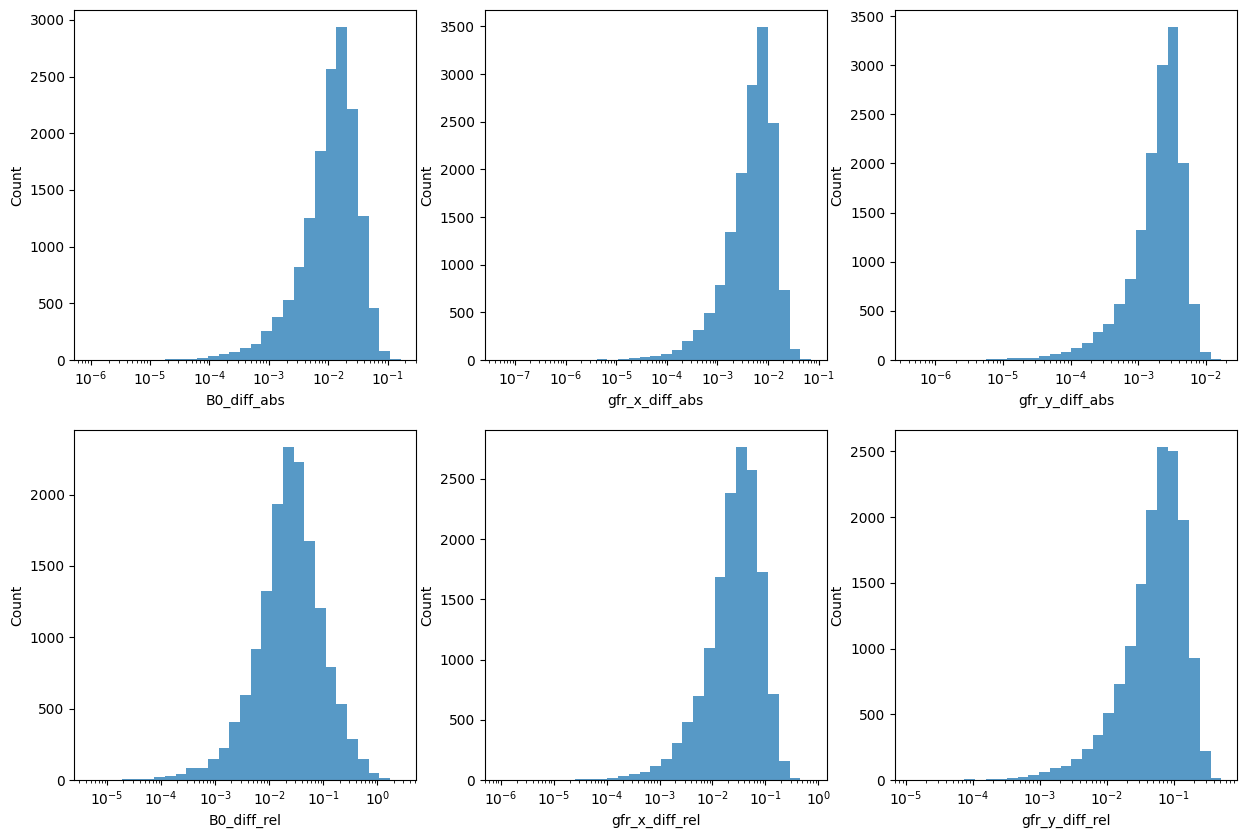

In [54]:

fig, axes = plt.subplots(2,3,figsize=(15,10))

for x,y,colname in [(0,0,"B0_diff_abs"),(0,1,"gfr_x_diff_abs"),(0,2,"gfr_y_diff_abs"),(1,0,"B0_diff_rel"),(1,1,"gfr_x_diff_rel"),(1,2,"gfr_y_diff_rel")]:
    log_min = np.log10(df[colname].min())
    log_max = np.log10(df[colname].max())
    bins = np.logspace(log_min, log_max, 30) 
    sns.histplot(ax=axes[x,y],data=df,x=colname,bins=bins)
    axes[x,y].set_xscale("log")

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(15,5))


# From here: Input Optim

In [138]:
A = []
b = []

def onehot(name, neg):
    out = [0] * len(important_cols_order)
    out[important_cols_order.index(name)] = -1 if neg else 1
    return out

for name in important_cols_order:
    # constraints for minima: x > a --> -x < -a
    A.append(onehot(name,True))
    b.append(-dataset_train.input_mins[name])
    
    # constraints for maxima: x < a
    if name == "usedPowerInPercent":
        A.append(onehot(name,False))
        b.append(100)
    else:
        A.append(onehot(name,False))
        b.append(dataset_train.input_maxs[name])

In [139]:
A_rel = []
b_rel = []

#['fieldTolerance', 'maxCurrentDensity', 'rho0', 'usedPowerInPercent', 'w_leg_factor', 'B_design', 'aper_x', 'aper_y']

# aper_x > aper_y --> aper_y - aper_x < 0
A_rel.append([0, 0, 0, 0, 0, 0, -1, 1])
b_rel.append(0)

# aper_x < 5 * aper_y --> aper_x - 5 * aper_y < 0
A_rel.append([0, 0, 0, 0, 0, 0, 1, -3])
b_rel.append(0)



A = A + A_rel
b = b + b_rel

In [140]:
# ratio constraints 
# compute min and max ratio for every pair of inputs and ensure the ratio is in that range with two linear constraints
# e.g. min < a/b < max -->  min * b - a < 0 and a - max * b < 0
# with slack. min * (1+e) < a/b < max * (1-e) -->  (min (1+ e)) * b - a < 0 and a - (max*(1-e)) * b < 0

A_rat = []
b_rat = []
epsilon = 1e-5

for i in range(len(important_cols_order)-1):
    for j in range(i+1,len(important_cols_order)):
        quantity_1 = important_cols_order[i]
        quantity_2 = important_cols_order[j]

        # ratio = column i/ colimn j
        ratio_df = dataset_train.dataframe.assign(ratio=dataset_train.dataframe.apply(lambda r: r[quantity_1] / r[quantity_2], axis=1))

        minimum = ratio_df["ratio"].min() 
        maximum = ratio_df["ratio"].max()

        minimum *= 1+epsilon
        maximum *= 1-epsilon

        # min * j - i < 0
        min_row = [0]*len(important_cols)
        min_row[i] = -1
        min_row[j] = minimum
        A_rat.append(min_row)
        b_rat.append(0)

        #i - max * k < 0
        max_row = [0]*len(important_cols)
        max_row[i] = 1
        max_row[j] = -maximum
        A_rat.append(max_row)
        b_rat.append(0)

        print(quantity_1,quantity_2,minimum,maximum, "-->", min_row,"< 0 and", max_row,"< 0")


A = A + A_rat
b = b + b_rat

fieldTolerance maxCurrentDensity 1.0000100000000001e-05 0.0199998 --> [-1, 1.0000100000000001e-05, 0, 0, 0, 0, 0, 0] < 0 and [1, -0.0199998, 0, 0, 0, 0, 0, 0] < 0
fieldTolerance rho0 0.00010000100000000001 0.0199998 --> [-1, 0, 0.00010000100000000001, 0, 0, 0, 0, 0] < 0 and [1, 0, -0.0199998, 0, 0, 0, 0, 0] < 0
fieldTolerance usedPowerInPercent 8.000080000000001e-07 0.0009372486996250448 --> [-1, 0, 0, 8.000080000000001e-07, 0, 0, 0, 0] < 0 and [1, 0, 0, -0.0009372486996250448, 0, 0, 0, 0] < 0
fieldTolerance w_leg_factor 4.12525439843647e-05 0.012253019520256961 --> [-1, 0, 0, 0, 4.12525439843647e-05, 0, 0, 0] < 0 and [1, 0, 0, 0, -0.012253019520256961, 0, 0, 0] < 0
fieldTolerance B_design 5.0000500000000003e-05 0.13557761627338663 --> [-1, 0, 0, 0, 0, 5.0000500000000003e-05, 0, 0] < 0 and [1, 0, 0, 0, 0, -0.13557761627338663, 0, 0] < 0
fieldTolerance aper_x 0.00033333666666666674 0.33333000000000007 --> [-1, 0, 0, 0, 0, 0, 0.00033333666666666674, 0] < 0 and [1, 0, 0, 0, 0, 0, -0.33333

In [141]:
target = torch.tensor([1.8,0.045,0.025], device=device,dtype=torch.double)
loss_fun = torch.nn.MSELoss()

In [142]:
def project_to_polytope(x, A_mat=A, b_vec = b):
    # Define decision variable
    p = cp.Variable(len(x))
    # Define objective function
    objective = cp.Minimize(cp.sum_squares(p - x))

    # Define constraints
    constraints = [np.array(A_mat) @ p <= np.array(b_vec)]

    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()


    # Optimal solution
    closest_point = p.value
    return closest_point

In [145]:
# init guess
guess = torch.randn((8),dtype=torch.double)
guess = network.B0_Net.bn0.running_mean[:8].clone().detach()

# initially project to ensure all values make sense and the continuous transformations make sense  as well
magnet_params = torch.tensor(project_to_polytope(guess.detach().cpu().numpy())).unsqueeze(0).to(device).requires_grad_(True)

lr = 1e-1
lr_tensor = network.B0_Net.bn0.running_mean[:8].clone().detach() * lr
print(lr_tensor.clone().detach())
network.eval()

n_steps = 2000

for step in range(n_steps):
    if magnet_params.grad is not None:
        magnet_params.grad.zero_()
    for layer in network.parameters():
        if layer.grad is not None:
            layer.grad.zero_()

    pred = network(magnet_params)
    #print(pred)
    # TODO only punish too small values
    loss = loss_fun(pred,target)
    #print(loss)

    print(f"{step}, {loss.detach().cpu().numpy():.12f}",end="\r")
    loss.backward()
    with torch.no_grad():        
        magnet_params = magnet_params - lr_tensor * magnet_params.grad
        proj_result = project_to_polytope(magnet_params.squeeze().detach().cpu().numpy())
        if (proj_result is None):
            magnet_params = torch.tensor(magnet_params).requires_grad_(True)
        else:        
            magnet_params = torch.tensor(proj_result).unsqueeze(0).to(device).requires_grad_(True)


magnet_params = torch.tensor(project_to_polytope(magnet_params.squeeze().detach().cpu().numpy())).unsqueeze(0).to(device).requires_grad_(True)
magnet_params



tensor([3.5459e-04, 5.2962e-01, 7.5313e-02, 7.1169e+00, 1.5582e-01, 9.4222e-02,
        1.3523e-02, 8.7637e-03], device='cuda:0', dtype=torch.float64)


/home/max/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[1.0000e-02, 5.4687e+00, 8.2521e-01, 9.1359e+01, 1.5339e+00, 2.0000e+00,
         1.5521e-01, 1.0363e-01]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)

In [146]:
import femmcreator
import magnetdesigner

In [147]:
magnet_params_np = magnet_params.squeeze().detach().cpu().numpy()

print(*list(*(magnet_params.detach().cpu().numpy())))
#['fieldTolerance', 'maxCurrentDensity', 'rho0', 'usedPowerInPercent', 'w_leg_factor', 'B_design', 'aper_x', 'aper_y']

magnet = magnetdesigner.designer.get_Dipole(
    name=name, 
    B_design=magnet_params_np[5], 
    aper_x=magnet_params_np[6], 
    aper_y=magnet_params_np[7], 
    fieldTolerance=magnet_params_np[0], 
    rho0=magnet_params_np[2], 
    w_leg_factor=magnet_params_np[4],
    maxCurrentDensity=magnet_params_np[1], 
    usedPowerInPercent=magnet_params_np[3], 
    shape="H")

femm = femmcreator.FEMM()
femm.Build(magnet.get_femminput)
femm.CreateFEMM('dipole_3_1.8_0.09_0.05')

0.01 5.468738028765966 0.8252056479543008 91.3594404460409 1.5338510257701794 1.9999999999999996 0.15521115139490943 0.10362962243180415


In [122]:
magnet.gfr_x

0.0765893655528386